In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sep
from astropy.io import fits

In [6]:
from sqlalchemy import create_engine
import pandas as pd

In [7]:
from astropy.stats import sigma_clipped_stats

In [8]:
engine = create_engine('sqlite:///../RBpipeline/newrbogus22-dev.db')

In [9]:
simulated = pd.read_sql_query("""SELECT * FROM Simulated""", engine)

In [10]:
dt_zps = pd.merge(pd.read_sql_table('Detected', engine),
                  pd.read_sql_query("""SELECT 
                                        Detected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM Detected
                                        LEFT JOIN Reals
                                            ON Detected.id==Reals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==Reals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [11]:
dt_ois = pd.merge(pd.read_sql_table('DetectedOIS', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedOIS.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedOIS
                                        LEFT JOIN RealsOIS
                                            ON DetectedOIS.id==RealsOIS.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsOIS.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [12]:
dt_hot = pd.merge(pd.read_sql_table('DetectedHOT', engine),
                  pd.read_sql_query("""SELECT 
                                        DetectedHOT.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM DetectedHOT
                                        LEFT JOIN RealsHOT
                                            ON DetectedHOT.id==RealsHOT.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==RealsHOT.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [13]:
dt_sps = pd.merge(pd.read_sql_table('SDetected', engine),
                  pd.read_sql_query("""SELECT 
                                        SDetected.id,
                                        Simulated.app_mag as sim_mag,
                                        Simulated.id as sim_id 
                                    FROM SDetected
                                        LEFT JOIN SReals
                                            ON SDetected.id==SReals.detected_id
                                        LEFT JOIN Simulated
                                            ON Simulated.id==SReals.simulated_id""", engine),
                                      on='id', suffixes=('',''))

In [14]:
images = pd.read_sql_table('Images', engine)

In [15]:
nbog = np.zeros(500)
nobjs = np.zeros(500)
i = 0
for img in images.iterrows():
    path = img[1].path
    path = path[:-9]+'ref.fits'
    #print path
    objs = dt_zps[dt_zps.image_id == img[1].id]
    nbog[i] = np.sum(objs.IS_REAL==False)
    try:
        img_data = fits.getdata(path).byteswap().newbyteorder()
        st = sigma_clipped_stats(img_data)
        srcs = sep.extract(img_data - sep.Background(img_data), st[2])
        #srcs = sep.extract(img_data - sep.Background(img_data), 15.)
        nobjs[i] = len(srcs)
    except:
        nobjs[i] = -99
    i+=1

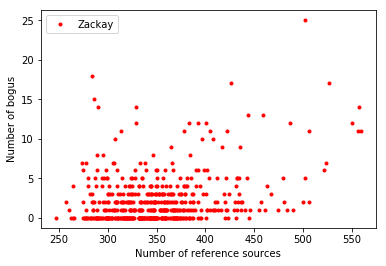

In [16]:
plt.plot(nobjs, nbog, 'r.', label='Zackay')
#plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')

In [17]:
nbog = np.zeros(500)
i = 0
for img in images.iterrows():
    path = img[1].path
    path = path[:-9]+'ref.fits'
    #print path
    objs = dt_ois[dt_ois.image_id == img[1].id]
    nbog[i] = np.sum(objs.IS_REAL==False)
    i+=1

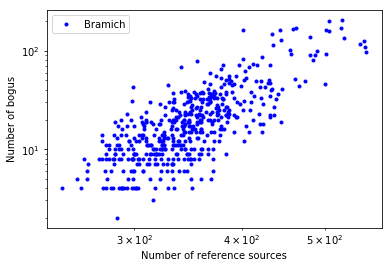

In [18]:
plt.plot(nobjs, nbog, 'b.', label='Bramich')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')

In [19]:
nbog = np.zeros(500)
i = 0
for img in images.iterrows():
    path = img[1].path
    path = path[:-9]+'ref.fits'
    #print path
    objs = dt_hot[dt_hot.image_id == img[1].id]
    nbog[i] = np.sum(objs.IS_REAL==False)
    i+=1

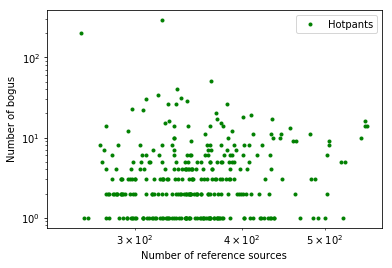

In [20]:
plt.plot(nobjs, nbog, 'g.', label='Hotpants')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')

In [21]:
nbog = np.zeros(500)
i = 0
for img in images.iterrows():
    path = img[1].path
    path = path[:-9]+'ref.fits'
    #print path
    objs = dt_sps[dt_sps.image_id == img[1].id]
    nbog[i] = np.sum(objs.IS_REAL==False)
    i+=1

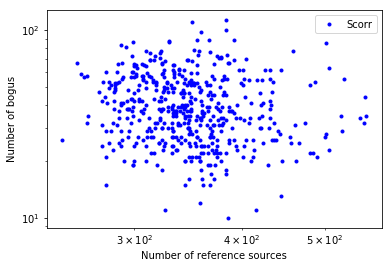

In [22]:
plt.plot(nobjs, nbog, 'b.', label='Scorr')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')

In [23]:
def nbogs(dataset, images):
    nbog = np.zeros(500)
    i = 0
    for img in images.iterrows():
        path = img[1].path
        path = path[:-9]+'ref.fits'
        #print path
        objs = dataset[dataset.image_id == img[1].id]
        nbog[i] = np.sum(objs.IS_REAL==False)
        i+=1
    return nbog

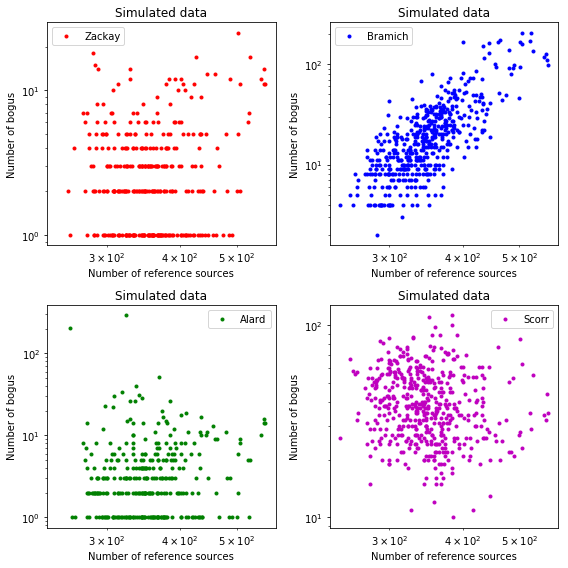

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
nbog = nbogs(dt_zps, images)
plt.plot(nobjs, nbog, 'r.', label='Zackay')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')
plt.title('Simulated data')

plt.subplot(222)
nbog = nbogs(dt_ois, images)
plt.plot(nobjs, nbog, 'b.', label='Bramich')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')
plt.title('Simulated data')

plt.subplot(223)
nbog = nbogs(dt_hot, images)
plt.plot(nobjs, nbog, 'g.', label='Alard')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')
plt.title('Simulated data')

plt.subplot(224)
nbog = nbogs(dt_sps, images)
plt.plot(nobjs, nbog, 'm.', label='Scorr')
plt.loglog()
plt.xlabel('Number of reference sources')
plt.ylabel('Number of bogus')
plt.legend(loc='best')
plt.title('Simulated data')

plt.tight_layout()

In [21]:
np.mean(nbog)

2.3479999999999999

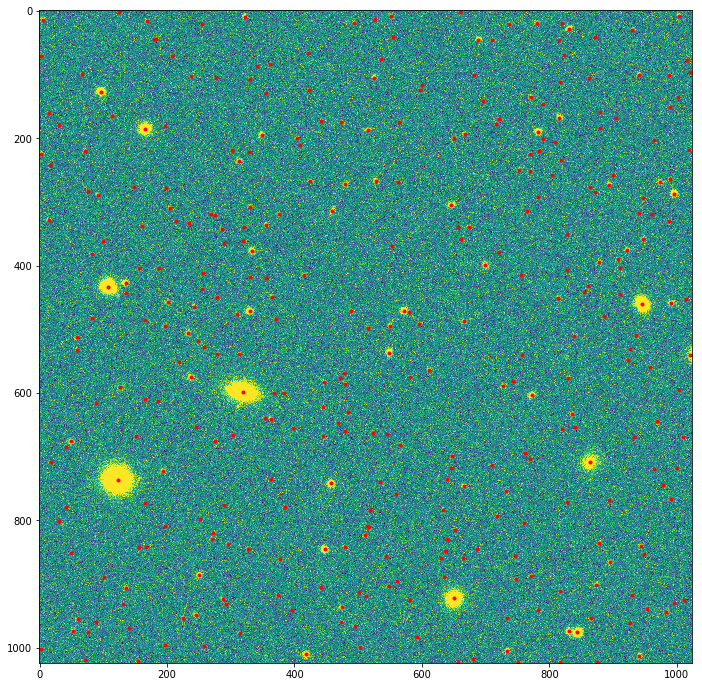

In [12]:
st = sigma_clipped_stats(img_data)
srcs = sep.extract(img_data - sep.Background(img_data), st[2])
plt.figure(figsize=(12, 12))
plt.imshow(img_data, vmax=3*st[2]+st[0], vmin=st[0]-3*st[2])
plt.plot(srcs['x'], srcs['y'], 'r.')

In [86]:
len(srcs)

1